# Description

In [1]:
#1 get GC content from contigs
    #get GC content in set chunk sizes
    
#2 get coverage for contigs
    #get coverage in chunk sizes

#3 blob plot gc vs average coverage

#4 plot gc content/coverage for each contig (if significant in some way)

#5 kmeans clusters

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import csv
import os
import shutil

# Parameters

In [3]:
assembly = "./data/final.p_ctg_test.fasta"
coverage_per_contig = "./data/heliopora_coerulea_hifi_2_p_assembly.coverage"
coverage_per_base = "./data/heliopora_coerulea_hifi_2_p_assembly_testfile.depth"
out_dir = "out_dir/"
chunk_size = 10000
visualize_GC = True
save_GC_plot = True
visualize_Coverage = True
save_coverage_plot = True
threshold_pct = 50
visualize_blob = True
save_blob_plot = True

# Naive GC content for each content

In [4]:
def get_gc_content(fasta_file):
    """
    Reads in a FASTA file and returns a dictionary mapping contig IDs to their GC content
    """
    gc_content = {}
    current_id = None
    current_seq = ""
    
    with open(fasta_file, "r") as f:
        for line in f:
            if line.startswith(">"):
                # If this is a new contig, calculate the GC content for the previous one (if there was one)
                if current_id is not None:
                    gc_content[current_id] = (current_seq.count("G") + current_seq.count("C")) / len(current_seq)
                
                # Start the new contig
                current_id = line.strip()[1:].split("/")[3]
                current_seq = ""
            else:
                current_seq += line.strip()
    
    # Calculate GC content for the final contig
    gc_content[current_id] = (current_seq.count("G") + current_seq.count("C")) / len(current_seq)
    
    return gc_content

In [5]:
naive_gc = get_gc_content(assembly)
print(naive_gc)

{'000409': 0.4361125376490347, '000412': 0.3682002202177709, '000414': 0.432141441853376, '000417': 0.3836783928662018, '000419': 0.4775867105714715}


# GC content for each contig by averaging in given chunk sizes

In [6]:
def get_gc_content_chunks(fasta_file, chunk_size):
    """
    Reads in a FASTA file and returns a dictionary mapping contig IDs to a list of gc content per chunk size
    """
    gc_content = {}
    current_id = None
    current_seq = ""
    chunks = []
    
    with open(fasta_file, "r") as f:
        for line in f:
            if line.startswith(">"):
                # If this is a new contig, calculate the GC content for the previous one (if there was one)
                if current_id is not None:
                    i = 0
                    while i < len(current_seq):
                        # check for last chunk
                        if (i + chunk_size) > len(current_seq):
                            end = len(current_seq)
                        else:
                            end = i + chunk_size
                        sub = current_seq[i:end]
                        gc = round(((sub.count("G") + sub.count("C")) / len(sub)),2)
                        chunks.append(gc)
                        i = end
                    # add to dictionary in form {current_id : [array of GC content of given chunk size]}
                    gc_content[current_id] = chunks
                
                # Start the new contig
                current_id = line.strip()[1:]
                current_seq = ""
                chunks = []
                
            else:
                current_seq += line.strip()
                
        # calculate GC content for the last contig
        if current_id is not None:
            i = 0
            while i < len(current_seq):
                # check for last chunk
                if (i + chunk_size) > len(current_seq):
                    end = len(current_seq)
                else:
                    end = i + chunk_size
                sub = current_seq[i:end]
                gc = round(((sub.count("G") + sub.count("C")) / len(sub)), 2)
                chunks.append(gc)
                i = end
            # add to dictionary in form {current_id : [array of GC content of given chunk size]}
            gc_content[current_id] = chunks
        
    return gc_content

In [7]:
chunks = get_gc_content_chunks(assembly, chunk_size)

#print(chunks)
gc_trimmed_mean = {}
#Get the trimmed mean from chunks
for entry in chunks:
    #print(entry)
    new_entry = entry.split("/")[3]
    gc_trimmed_mean[new_entry] = stats.trim_mean(chunks.get(entry), 0.05)
print(gc_trimmed_mean)

{'000409': 0.43685714285714294, '000412': 0.36941176470588233, '000414': 0.4332258064516128, '000417': 0.3844117647058823, '000419': 0.47794117647058826}


# Visualize GC content 

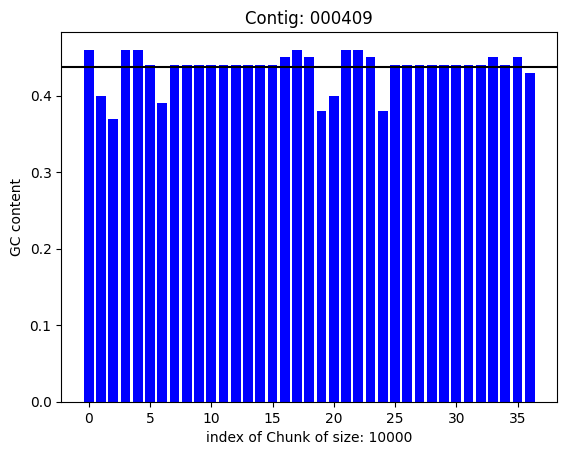

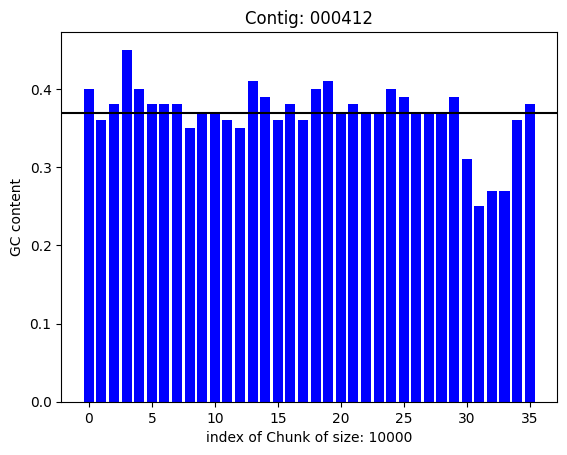

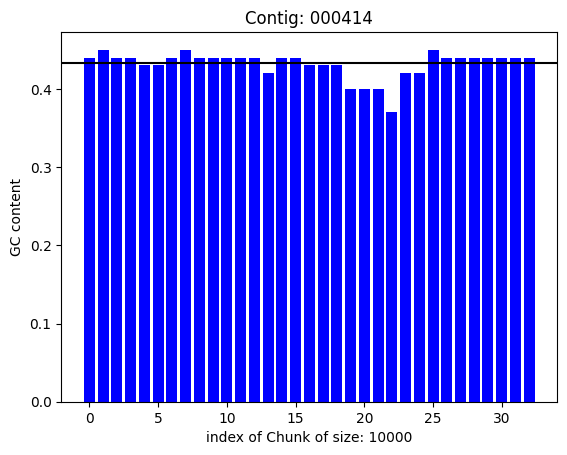

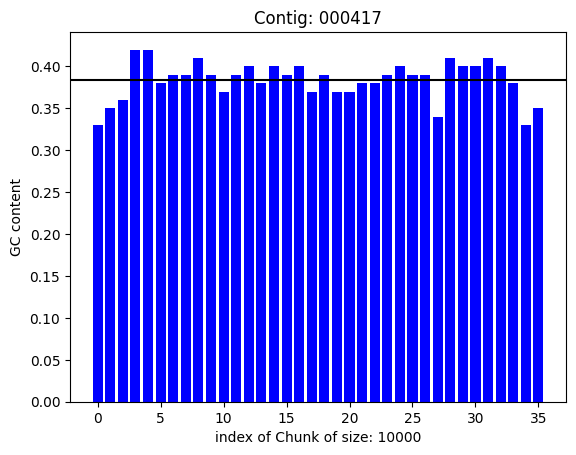

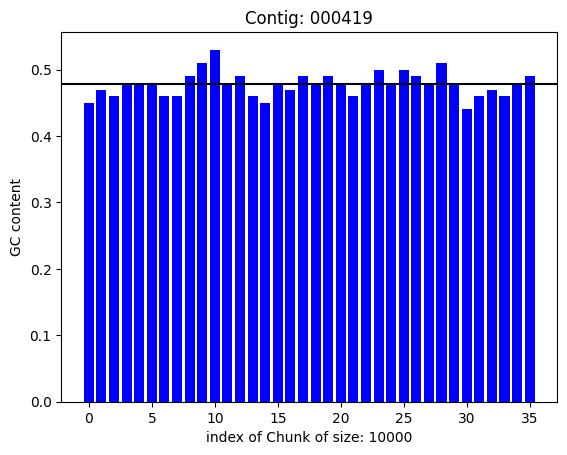

In [8]:
if save_GC_plot:
    save_dir = out_dir + "./GC_visual_output"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

if visualize_GC:
    for id, gc_content in chunks.items():
        #format id
        id = id.split("/")[3]
        
        # create a bar plot
        fig, ax = plt.subplots()
        mean_gc = np.mean(gc_content)
        colors = ['red' if abs(gc - mean_gc) / mean_gc * 100 >= threshold_pct else 'blue' for gc in gc_content]
        plt.bar(range(len(gc_content)), gc_content, color=colors)
        ax.axhline(y=gc_trimmed_mean[id], color='black')
        plt.title("Contig: " + str(id))
        plt.xlabel('index of Chunk of size: ' + str(chunk_size))
        plt.ylabel('GC content')

        # save the plot
        if save_GC_plot:
            save_path = os.path.join(save_dir, "GC_content_" + str(id) + ".png")
            plt.savefig(save_path)

        # show the plot
        plt.show()

else:
    print("GC visualization is turned off.")

# Naive coverage

In [9]:
def get_coverage_per_contig(coverage_file):
    naive_coverage = {}

    with open(coverage_file, "r") as f:
        next(f)
        for line in f:
            # Split line into columns
            columns = line.strip().split("\t")

            # Use the first column as key and the sixth column as value
            key = columns[0].split("/")[3]
            value = columns[5]

            # Add key-value pair to dictionary
            naive_coverage[key] = value
            
    f.close()
    return naive_coverage

In [10]:
naive_coverage = get_coverage_per_contig(coverage_per_contig)
#print(naive_coverage)

# Chunk averaged Coverage

In [11]:
def get_coverage_per_contig_by_chunks(depth_file, chunk_size):
    save_dir = out_dir + "Coverage_output/"
    
    # Define a dictionary to store the coverage data for each ID
    id_data = {}

    # Read in the TSV file
    with open(depth_file, 'r') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')

        # Iterate over each row in the file
        for row in reader:
            # Extract the ID, index, and coverage from the row
            id = row[0].split("/")[3]
            index = int(row[1])
            coverage = float(row[2])

            # Check if this is the first row for this ID
            if id not in id_data:
                id_data[id] = []

            # Find the window index for this row
            window_index = index // chunk_size

            # Check if there is already coverage data for this window
            if len(id_data[id]) <= window_index:
                # Add a new entry for this window
                id_data[id].append({'window_sum': coverage, 'window_count': 1})
            else:
                # Add the coverage to the existing window data
                id_data[id][window_index]['window_sum'] += coverage
                id_data[id][window_index]['window_count'] += 1

    # Write the output to a file
    with open(save_dir + "chunked_windows_coverage.tsv", 'w') as outfile:
        outfile.write("id\tindex\taverage_coverage\n")
        for id, windows in id_data.items():
            for i, window in enumerate(windows):
                if window['window_count'] > 0:
                    avg_coverage = round((window['window_sum'] / window['window_count']), 2)
                    outfile.write(f"{id}\t{i}\t{avg_coverage}\n")
    outfile.close()
    
    #now get the average coverage for each id
        
    # Open the input file
    with open(save_dir + "chunked_windows_coverage.tsv", "r") as f:
        next(f)
        # Create a dictionary to store the total coverage and highest index for each id
        id_coverage = {}
        # Read through each line in the file
        for line in f:
            # Split the line into three columns
            id, index, coverage = line.strip().split("\t")
            # Convert the coverage to float
            index = float(index)
            coverage = float(coverage)
            # If the id is not in the dictionary yet, add it with a coverage of 0 and index of -1
            if id not in id_coverage:
                id_coverage[id] = {"coverage": 0, "max_index": -1}
            # Add the coverage to the total for this id
            id_coverage[id]["coverage"] += coverage
            # Update the max index for this id if the current index is higher
            if index > id_coverage[id]["max_index"]:
                id_coverage[id]["max_index"] = index
    f.close()
    
    #make list of coverages, then take trimmed mean of that list
    coverage_trimmed_mean = {}
    for entry in id_data:
        coverages = []
        for chunk in id_data.get(entry):
            window_sum = float(chunk.get('window_sum'))
            window_count = float(chunk.get('window_count'))
            coverage = round((window_sum / window_count), 2)
            coverages.append(coverage)
        
        coverage_trimmed_mean[entry] = round(stats.trim_mean(coverages, 0.05), 2)
        
    # Open the output file
    with open(save_dir + "chunked_coverage.tsv", "w") as f:
        # Write the header row
        f.write("id\taverage_coverage\n")
        # Loop through the ids in the dictionary
        for id in coverage_trimmed_mean:
            average_coverage = coverage_trimmed_mean[id]
            f.write("{}\t{}\n".format(id, average_coverage))
    f.close()

    return id_data

In [12]:
chunks_coverage = get_coverage_per_contig_by_chunks(coverage_per_base, chunk_size)

# Visualize Coverage

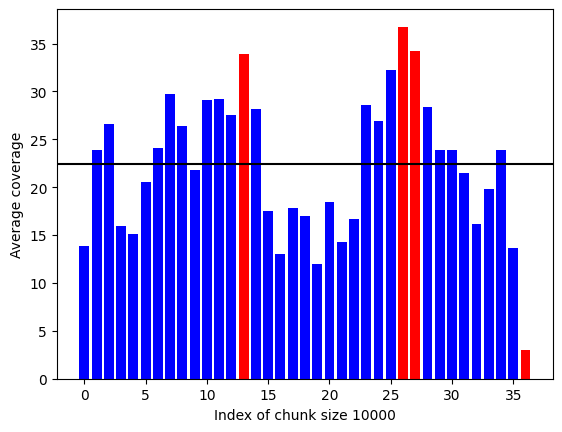

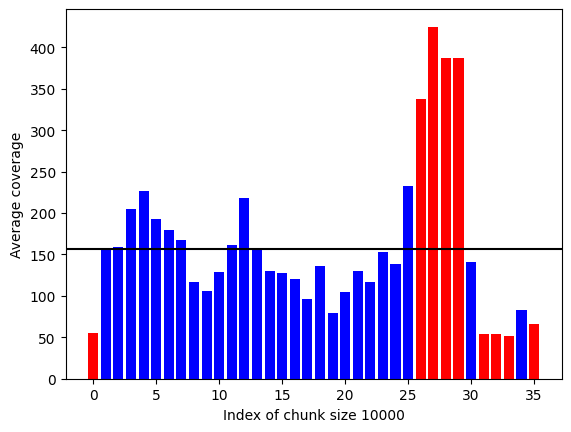

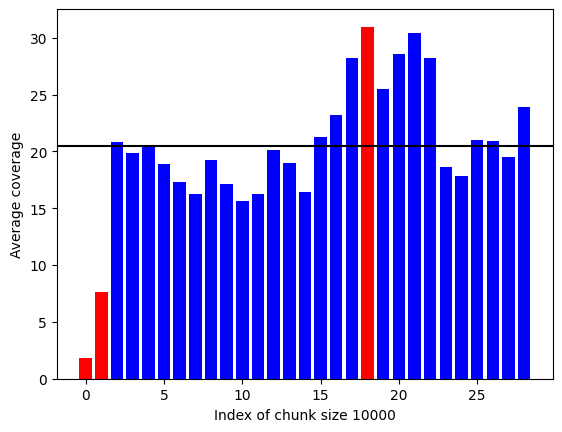

In [13]:
if save_coverage_plot:
    save_dir = out_dir + "Coverage_output/"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

if visualize_Coverage:
    
    #windows
    data = pd.read_csv(save_dir + "chunked_windows_coverage.tsv", dtype={'id': 'object'}, sep = "\t")
    trimmed_mean = pd.read_csv(save_dir + "chunked_coverage.tsv", dtype={'id': 'object'}, sep = "\t")
    
    # Convert data to pandas dataframe
    df = pd.DataFrame(data)
    mean = pd.DataFrame(trimmed_mean)
    # Group data by id
    groups = df.groupby('id')
    # Get a list of unique ids
    unique_ids = df['id'].unique()
    
    # Create a separate plot for each id
    for id in unique_ids:
        # Filter the dataframe to get only the rows for this id
        df_id = df[df['id'] == id]
        
        fig, ax = plt.subplots()
        trimmed_mean_coverage = float(mean.loc[mean['id'] == id, 'average_coverage'])
        ax.axhline(y=trimmed_mean_coverage, color='black')

        #filtered colors
        colors = ['red' if abs(coverage - trimmed_mean_coverage) / trimmed_mean_coverage * 100 >= threshold_pct else 'blue' for coverage in df_id['average_coverage']]

        # Plot the data for this id
        plt.bar(df_id['index'], df_id['average_coverage'], label=f"id={id}", color=colors)
        
        # Add labels and legend
        plt.xlabel('Index of chunk size ' + str(chunk_size))
        plt.ylabel('Average coverage')

        # save the plot
        if save_coverage_plot:
            save_path = os.path.join(save_dir, "Coverage_" + str(id) + ".png")
            plt.savefig(save_path)
        
        # Show the plot
        plt.show()
        
else :
    print("Coverage visualization is turned off.")

# Blob Plot

       id  gc_content average_coverage
0  000409    0.436113              100
1  000412    0.368200            99.67
2  000414    0.432141          99.6519
3  000417    0.383678              100
4  000419    0.477587              100


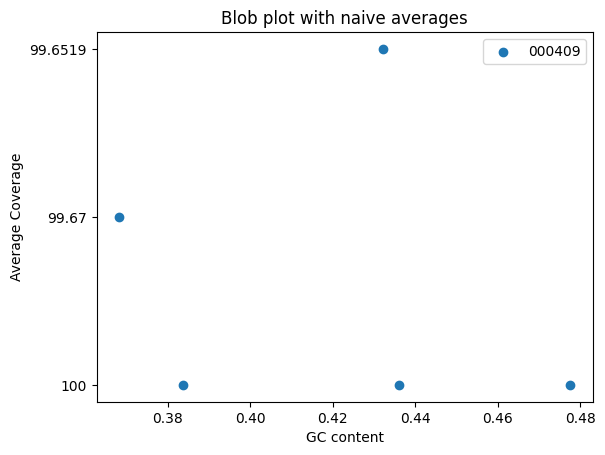

In [14]:
#plot gc content (x) vs coverage (y)
if visualize_blob:
    
    #plot 1 naive
    data = [{'id': k, 'gc_content': v} for k, v in naive_gc.items()]
    data2 = [{'id': k, 'average_coverage': v} for k, v in naive_coverage.items()]
    # Convert the list of dictionaries to dataframes
    df1 = pd.DataFrame(data)
    df2 = pd.DataFrame(data2)
    naive_df = pd.merge(df1, df2, on = 'id')
    print(naive_df)
    
    plt.scatter(naive_df['gc_content'], naive_df['average_coverage'])
    # Add labels and legend
    plt.xlabel('GC content')
    plt.ylabel('Average Coverage')
    plt.title('Blob plot with naive averages')
    plt.legend(list(naive_df['id']), loc="upper right")
    
    # save the plot
    if save_blob_plot:
        save_path = os.path.join(out_dir, "Blob_naive.png")
        plt.savefig(save_path)

    # Show the plot
    plt.show()

       id  gc_content  average_coverage
0  000409    0.436857             22.45
1  000412    0.369412            156.09
2  000414    0.433226             20.45


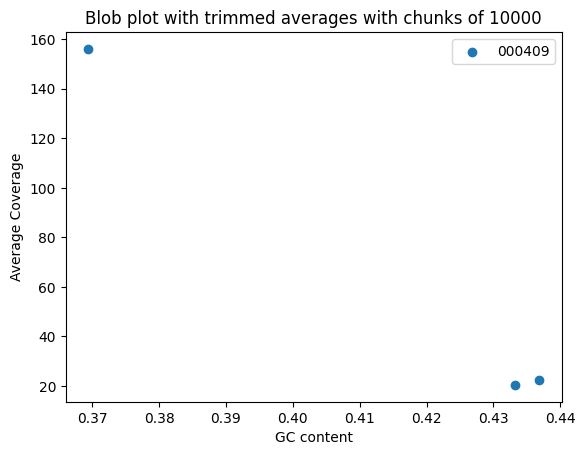

In [17]:
if visualize_blob:
    #plot 2 trimmed/chunked
    
    data = [{'id': k, 'gc_content': v} for k, v in gc_trimmed_mean.items()]
    # Convert the list of dictionaries to dataframes
    df1 = pd.DataFrame(data)
    trimmed_df = pd.merge(df1, trimmed_mean, on = 'id')
    print(trimmed_df) 
    
    labels = list(trimmed_df['id'])
    plt.scatter(trimmed_df['gc_content'], trimmed_df['average_coverage'])
    # Add labels and legend
    plt.xlabel('GC content')
    plt.ylabel('Average Coverage')
    plt.title('Blob plot with trimmed averages with chunks of ' + str(chunk_size))
    plt.legend(labels, loc="upper right")
    
    # save the plot
    if save_blob_plot:
        save_path = os.path.join(out_dir, "Blob.png")
        plt.savefig(save_path)

    # Show the plot
    plt.show()

In [16]:
print(list(naive_df['id']))

['000409', '000412', '000414', '000417', '000419']
